# <font  color = "#0093AF"> $T_1$, Nuclear Overhauser Effect in Solution NMR

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter2/Ch2_T1_NOE.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

In the following, we will mimic $T_1$ relaxation and heteronuclear NOE transfer resulting from tumbling in solution. The simplest way to do this is to utilize a tetrahedral hopping motion, however, note that this only results in isotropic averaging to interactions that are initially aligned along the $z$-axis.

## Setup

In [0]:
# SETUP pyDR
import os
os.chdir('../..')

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the spin-system
Note, that if motion is supposed to induce longitudinal relaxation ($T_1$, NOE), it is required to calculate in the laboratory frame, by setting LF=True at the beginning of the setup. Adding explicit relaxation (via L.add_relax), however, does not require a lab-frame calculation.

In [3]:
ex0=sl.ExpSys(v0H=400,Nucs=['15N','1H'],vr=0,LF=True)
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)

# Set up 4-site motion
ex,kex=sl.Tools.SetupTumbling(ex0,tc=1e-9,q=1) #Defaults to the magic angle, which will average the couplings

L=sl.Liouvillian(*ex,kex=kex)
seq=L.Sequence(Dt=.1)

## Observe $T_1$ relaxation of $^1$H and $^{15}$N

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

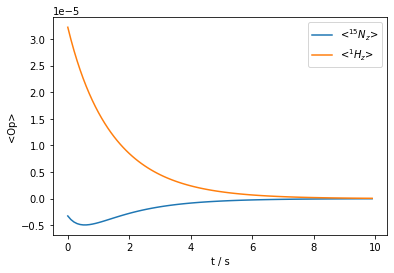

In [4]:
rho=sl.Rho('Thermal',['15Nz','1Hz'])
rho.DetProp(seq,n=100)
rho.plot(axis='s')

We observe both spins start from their thermal equilibrium and decay towards zero. Note that exchange in simulations only can destroy magnetization, so that this approach always forces the magnetization towards zero. We may add a correction term in SLEEPY, that will cause the magnetization to approach thermal equilibrium rather than zero. This is included as the "DynamicThermal" option. We start the magnetization at zero and allow both spins to recover.

## Relaxing towards thermal equilibrium

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

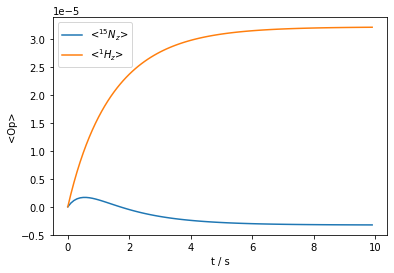

In [5]:
L.add_relax('DynamicThermal')
rho=sl.Rho('zero',['15Nz','1Hz'])
rho.DetProp(seq,n=100)
rho.plot(axis='s')

"DynamicThermal" works by calculating the full Liouvillian (referred to here as $\hat{\hat{L}}_0$) and equilibrium density matrix, $\hat{\rho}_{eq}$. Then, a correction term is calculated, such that:

$$
\hat{\rho}_{corr}=-\hat{\hat{L}}_0\cdot\hat{\rho}_{eq}
$$

Then, if $\hat{\rho}=\hat{\rho}_{eq}$, the sum of the production of the Liouvillian and the density matrix and the correction term is zero:

$$
\frac{d}{dt}\hat{\rho}=\hat{\hat{L}}_0\cdot\hat{\rho}+\hat{\rho}_{corr}
$$

The correction term is inserted into the Liouvillian such that it only interacts with the identity in the density matrix. Remember, the density matrix is extended to a vector in Liouville space. However, take for example, a 2-spin-1/2 system. The 4x4 identity matrix is stretched into a 16 element vector, with elements at the 0th, 5th, 10th, and 15th position. In this system, we have four states in exchange, so that yields elements at positions: 0,5,10,15,16,21,26,31,32,37,42,47,48,53,58,63. We can see how this works in the plot below, where the columns corresponding to the listed positions are each occupied by the product $\hat{\hat{L}}_0\cdot\hat{\rho}_{eq}$

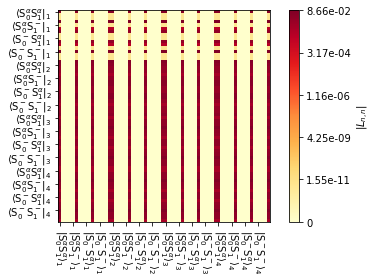

In [7]:
_=L.plot('Lrelax')

Then, it is important to note: this correction will result in polarization on, for example, the $\hat{S}_z$ term, by continually reducing the population of $\hat{S}_\beta$ and increasing the population of $\hat{S}_\alpha$ (this can equivalently be seen as an asymmetric transfer between the two populations). However, we also expect asymmetric transfer between, for example, the $\hat{I}^+\hat{S}_\alpha$ and $\hat{I}^+\hat{S}_\beta$ populations. This is what gives rise to, for example, the contact shift occuring due to fast relaxing electrons. However, both the $\hat{I}^+\hat{S}_\alpha$ and $\hat{I}^+\hat{S}_\beta$ terms are zero under thermal conditions, and therefore are not included in the "DynamicThermal" correction term, as we can see above where we note that the correction is calculated from the density matrix at thermal equilibrium, $\hat{\rho}_{eq}$. We will later see that we can correctly product contact and pseudo-contact shifts using Lindblad formalism,$^1$ but this is obtained with a different set of settings which we will use later for paramagnetic effects.

[1] C. Bengs, M. Levitt. *[J. Magn. Reson](https://doi.org/10.1016/j.jmr.2019.106645)*. **2020**, 310,106645.

## Obtaining the NOE enhancement

Finally, we may see how saturating one spin can lead to a change in the magnetization on the second spin via the Nuclear Overhauser Effect.$^1$

Here, we have to use a special tool in SLEEPY to apply a field in the lab frame. Keep in mind, longitudinal relaxation is driven by terms in the Hamiltonian that are dropped when we go to the rotating frame. However, in the lab frame, the applied RF fields are no longer time-independent and need to be explicitly simulated. SLEEPY uses several tricks for doing this. First, we get the time dependent field  based on two steps, and scale up the field strength/adjust the phase to get the . Then, we get the propagator including the two-step RF in its eigenbasis and propagate either for one step of the rotor period, or for Dt for a static sequence.

[1] A.W. Overhauser. *[Phys. Rev.](https://doi.org/10.1103/PhysRev.92.411)*, **1953**, 92, 411-415.

In [11]:
seq=L.Sequence(Dt=.1).add_channel('1H',v1=500)
lfrf=sl.LFrf(seq)

[<AxesSubplot:ylabel='$v_1$ / kHz'>,
 <AxesSubplot:xlabel='t / $\\mu$s', ylabel='$v_1$ / kHz'>]

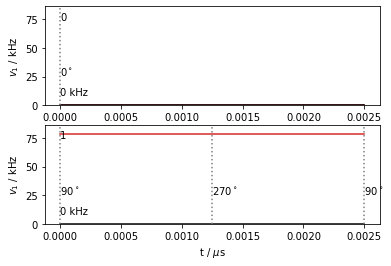

In [12]:
lfrf.seq.plot()

First, we get the propagator for the lab-frame RF. Then, we apply it to a system at thermal equilibrium, to observe it evolve away from thermal equilibrium due to the RF irradation.

LF calculation: |██████████████████████████████| 100% complete
Completed


<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

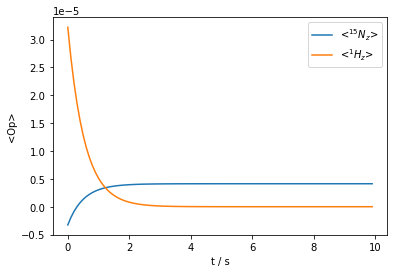

In [13]:
U=lfrf.U()

rho=sl.Rho('Thermal',['15Nz','1Hz'])
rho.DetProp(U,n=100)
rho.plot(axis='s')